# Imports and Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split, ConcatDataset
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import time

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device being used: {device}")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Device being used: cuda
Tesla T4


# Data Loading and Visualization

100%|██████████| 18.2M/18.2M [00:12<00:00, 1.46MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 280kB/s]
100%|██████████| 3.04M/3.04M [00:02<00:00, 1.36MB/s]
100%|██████████| 5.12k/5.12k [00:00<00:00, 20.6MB/s]


Using full dataset: 60000 samples.

Class Balance (Count per class):
{0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}


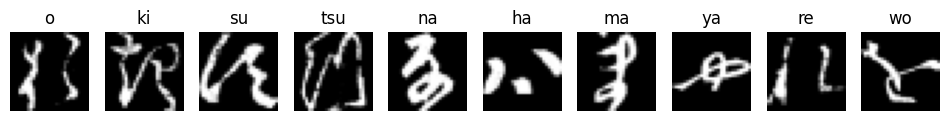

In [2]:
BATCH_SIZE = 64
SUBSET_SIZE = None

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_train_dataset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

if SUBSET_SIZE:
    indices = list(range(SUBSET_SIZE))
    full_train_dataset = Subset(full_train_dataset, indices)
    print(f"Using a subset of {SUBSET_SIZE} samples.")
else:
    print(f"Using full dataset: {len(full_train_dataset)} samples.")

def visualize_dataset(dataset):
    labels_map = {
        0: 'o', 1: 'ki', 2: 'su', 3: 'tsu', 4: 'na',
        5: 'ha', 6: 'ma', 7: 'ya', 8: 're', 9: 'wo'
    }

    targets = []
    if isinstance(dataset, Subset):
        targets = [dataset.dataset.targets[i] for i in dataset.indices]
    else:
        targets = dataset.targets.tolist()

    class_counts = {i: targets.count(i) for i in range(10)}
    print("\nClass Balance (Count per class):")
    print(class_counts)

    figure = plt.figure(figsize=(12, 4))
    cols, rows = 10, 1
    classes_found = set()

    temp_loader = DataLoader(dataset, batch_size=1, shuffle=True)

    idx = 1
    for img, label in temp_loader:
        lbl = label.item()
        if lbl not in classes_found:
            figure.add_subplot(rows, cols, lbl + 1)
            plt.title(labels_map[lbl])
            plt.axis("off")
            plt.imshow(img.squeeze(), cmap="gray")
            classes_found.add(lbl)
        if len(classes_found) == 10:
            break
    plt.show()

visualize_dataset(full_train_dataset)

# CNN Model Definition

In [3]:
class KMNIST_CNN(nn.Module):
    def __init__(self):
        super(KMNIST_CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.flatten(out)
        out = self.fc(out)
        return out

print("Model architecture defined.")

Model architecture defined.


# Helper Functions for Training and Evaluation

In [4]:

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / len(loader), correct / total

def validate_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / len(loader), correct / total

def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Method 1 - Hold-out Implementation

Starting Hold-out training for 15 epochs...
Epoch 1/15 | Train Loss: 0.2915, TrainAcc: 0.9114 | Val Loss: 0.0922, Val Acc: 0.9721
Epoch 2/15 | Train Loss: 0.0959, TrainAcc: 0.9718 | Val Loss: 0.0610, Val Acc: 0.9798
Epoch 3/15 | Train Loss: 0.0662, TrainAcc: 0.9800 | Val Loss: 0.0632, Val Acc: 0.9809
Epoch 4/15 | Train Loss: 0.0484, TrainAcc: 0.9853 | Val Loss: 0.0486, Val Acc: 0.9854
Epoch 5/15 | Train Loss: 0.0376, TrainAcc: 0.9885 | Val Loss: 0.0430, Val Acc: 0.9873
Epoch 6/15 | Train Loss: 0.0277, TrainAcc: 0.9916 | Val Loss: 0.0592, Val Acc: 0.9832
Epoch 7/15 | Train Loss: 0.0249, TrainAcc: 0.9924 | Val Loss: 0.0395, Val Acc: 0.9894
Epoch 8/15 | Train Loss: 0.0220, TrainAcc: 0.9926 | Val Loss: 0.0437, Val Acc: 0.9871
Epoch 9/15 | Train Loss: 0.0201, TrainAcc: 0.9933 | Val Loss: 0.0489, Val Acc: 0.9874
Epoch 10/15 | Train Loss: 0.0153, TrainAcc: 0.9951 | Val Loss: 0.0509, Val Acc: 0.9874
Epoch 11/15 | Train Loss: 0.0162, TrainAcc: 0.9950 | Val Loss: 0.0456, Val Acc: 0.9888
Epoch 12

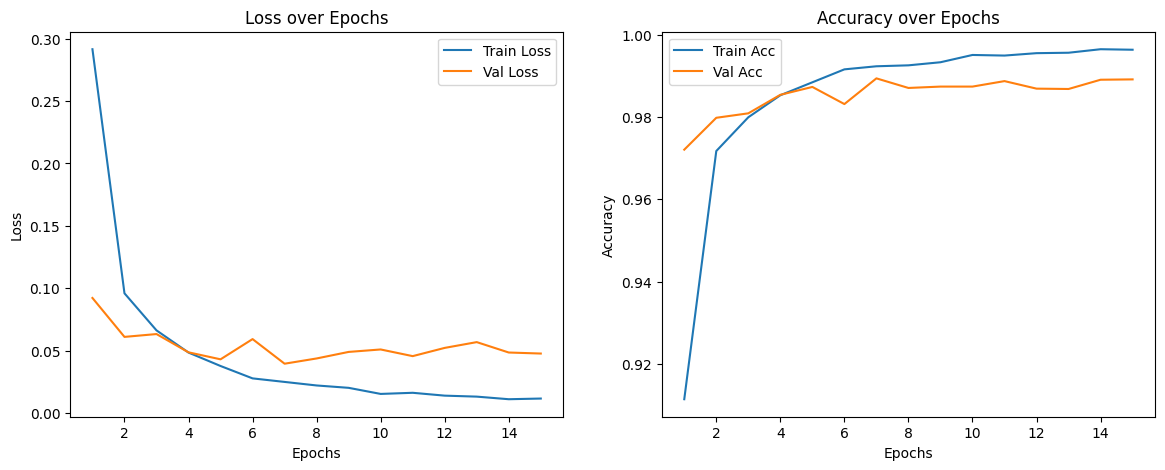

In [5]:
HOLD_OUT_EPOCHS = 15
LEARNING_RATE = 0.001

train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_ds, val_ds = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

model_holdout = KMNIST_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_holdout.parameters(), lr=LEARNING_RATE)

print(f"Starting Hold-out training for {HOLD_OUT_EPOCHS} epochs...")
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(HOLD_OUT_EPOCHS):
    train_loss, train_acc = train_epoch(model_holdout, train_loader, criterion, optimizer)
    val_loss, val_acc = validate_epoch(model_holdout, val_loader, criterion)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{HOLD_OUT_EPOCHS} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

plot_history(history)

# Hold-out Final Evaluation (Test Set)

Evaluating Hold-out model on Test Data...
Classification Report:
              precision    recall  f1-score   support

           0     0.9625    0.9760    0.9692      1000
           1     0.9717    0.9630    0.9674      1000
           2     0.9484    0.9190    0.9335      1000
           3     0.9554    0.9860    0.9705      1000
           4     0.9547    0.9480    0.9513      1000
           5     0.9766    0.9580    0.9672      1000
           6     0.9473    0.9890    0.9677      1000
           7     0.9877    0.9670    0.9773      1000
           8     0.9694    0.9810    0.9751      1000
           9     0.9838    0.9690    0.9763      1000

    accuracy                         0.9656     10000
   macro avg     0.9658    0.9656    0.9655     10000
weighted avg     0.9658    0.9656    0.9655     10000



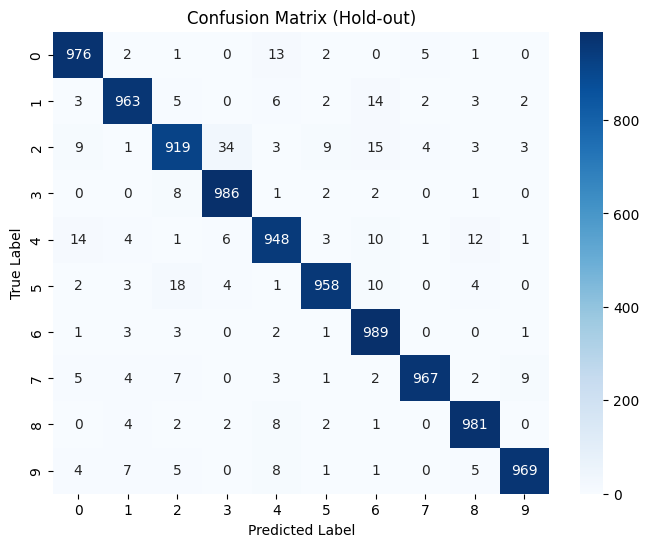

Per-class Accuracy: [0.976 0.963 0.919 0.986 0.948 0.958 0.989 0.967 0.981 0.969]
Final Hold-out Test Accuracy: 0.9656


In [6]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

def evaluate_final(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (Hold-out)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    print("Per-class Accuracy:", per_class_acc)

    return np.mean(np.array(all_preds) == np.array(all_labels))

print("Evaluating Hold-out model on Test Data...")
holdout_test_acc = evaluate_final(model_holdout, test_loader)
print(f"Final Hold-out Test Accuracy: {holdout_test_acc:.4f}")

# Method 2 - K-Fold Cross Validation & Hyperparameter Tuning

In [7]:
hyperparams_list = [
    {'lr': 0.001, 'batch_size': 128},
    {'lr': 0.0005, 'batch_size': 64}
]

K_FOLDS = 10
KFOLD_EPOCHS = 10

kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

results = {}

print(f"Starting {K_FOLDS}-Fold Cross Validation...")

for config in hyperparams_list:
    lr = config['lr']
    bs = config['batch_size']
    config_name = f"LR={lr}_BS={bs}"
    print(f"\nEvaluating Config: {config_name}")

    fold_accuracies = []

    for fold, (train_ids, val_ids) in enumerate(kfold.split(full_train_dataset)):
        train_sub = Subset(full_train_dataset, train_ids)
        val_sub = Subset(full_train_dataset, val_ids)

        train_l = DataLoader(train_sub, batch_size=bs, shuffle=True)
        val_l = DataLoader(val_sub, batch_size=bs, shuffle=False)

        model_cv = KMNIST_CNN().to(device)
        crit = nn.CrossEntropyLoss()
        opt = optim.Adam(model_cv.parameters(), lr=lr)

        for ep in range(KFOLD_EPOCHS):
            train_epoch(model_cv, train_l, crit, opt)

        _, val_acc = validate_epoch(model_cv, val_l, crit)
        fold_accuracies.append(val_acc)
        print(f"  Fold {fold+1}/{K_FOLDS}: Acc = {val_acc:.4f}")

    avg_acc = np.mean(fold_accuracies)
    results[config_name] = avg_acc
    print(f"--> Average Accuracy for {config_name}: {avg_acc:.4f}")

best_config_name = max(results, key=results.get)
print(f"\nBest Hyperparameters found: {best_config_name} with Avg Acc: {results[best_config_name]:.4f}")

Starting 10-Fold Cross Validation...

Evaluating Config: LR=0.001_BS=128
  Fold 1/10: Acc = 0.9860
  Fold 2/10: Acc = 0.9860
  Fold 3/10: Acc = 0.9842
  Fold 4/10: Acc = 0.9878
  Fold 5/10: Acc = 0.9875
  Fold 6/10: Acc = 0.9882
  Fold 7/10: Acc = 0.9917
  Fold 8/10: Acc = 0.9858
  Fold 9/10: Acc = 0.9863
  Fold 10/10: Acc = 0.9857
--> Average Accuracy for LR=0.001_BS=128: 0.9869

Evaluating Config: LR=0.0005_BS=64
  Fold 1/10: Acc = 0.9893
  Fold 2/10: Acc = 0.9862
  Fold 3/10: Acc = 0.9878
  Fold 4/10: Acc = 0.9858
  Fold 5/10: Acc = 0.9898
  Fold 6/10: Acc = 0.9902
  Fold 7/10: Acc = 0.9897
  Fold 8/10: Acc = 0.9890
  Fold 9/10: Acc = 0.9875
  Fold 10/10: Acc = 0.9872
--> Average Accuracy for LR=0.0005_BS=64: 0.9883

Best Hyperparameters found: LR=0.0005_BS=64 with Avg Acc: 0.9883


# Final Training with Best Config & Comparison

Retraining final model on FULL training set with LR=0.0005, BS=64...
Epoch 1/15 | Loss: 0.2935 | Acc: 0.9126
Epoch 2/15 | Loss: 0.0972 | Acc: 0.9708
Epoch 3/15 | Loss: 0.0659 | Acc: 0.9800
Epoch 4/15 | Loss: 0.0476 | Acc: 0.9856
Epoch 5/15 | Loss: 0.0384 | Acc: 0.9879
Epoch 6/15 | Loss: 0.0297 | Acc: 0.9907
Epoch 7/15 | Loss: 0.0249 | Acc: 0.9911
Epoch 8/15 | Loss: 0.0204 | Acc: 0.9935
Epoch 9/15 | Loss: 0.0183 | Acc: 0.9941
Epoch 10/15 | Loss: 0.0164 | Acc: 0.9948
Epoch 11/15 | Loss: 0.0136 | Acc: 0.9955
Epoch 12/15 | Loss: 0.0109 | Acc: 0.9962
Epoch 13/15 | Loss: 0.0132 | Acc: 0.9955
Epoch 14/15 | Loss: 0.0106 | Acc: 0.9967
Epoch 15/15 | Loss: 0.0075 | Acc: 0.9976

Evaluating Best K-Fold Model on Test Data...
Classification Report:
              precision    recall  f1-score   support

           0     0.9748    0.9680    0.9714      1000
           1     0.9725    0.9540    0.9631      1000
           2     0.9589    0.9090    0.9333      1000
           3     0.9211    0.9920    0.

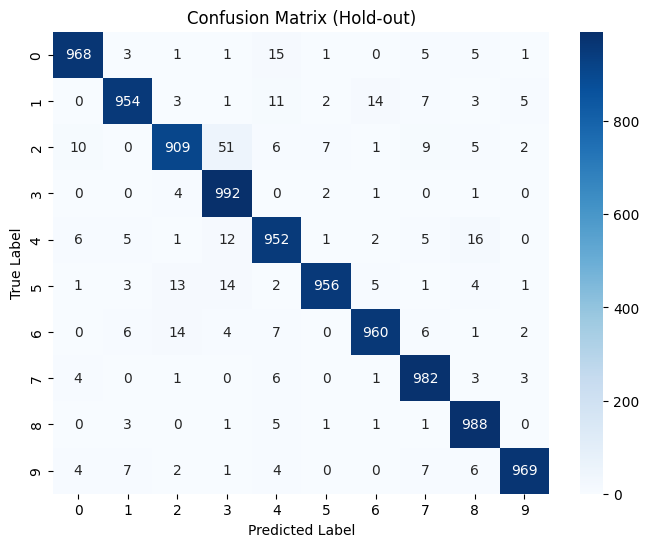

Per-class Accuracy: [0.968 0.954 0.909 0.992 0.952 0.956 0.96  0.982 0.988 0.969]

FINAL COMPARISON
Hold-out Method Test Accuracy: 0.9656
K-Fold Method Test Accuracy:   0.9630


In [9]:
best_lr = float(best_config_name.split('_')[0].split('=')[1])
best_bs = int(best_config_name.split('_')[1].split('=')[1])

print(f"Retraining final model on FULL training set with LR={best_lr}, BS={best_bs}...")

full_train_loader = DataLoader(full_train_dataset, batch_size=best_bs, shuffle=True)

final_model = KMNIST_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_lr)

FINAL_EPOCHS = 15
history_final = {'train_loss': [], 'train_acc': []}

for epoch in range(FINAL_EPOCHS):
    loss, acc = train_epoch(final_model, full_train_loader, criterion, optimizer)
    history_final['train_loss'].append(loss)
    history_final['train_acc'].append(acc)
    print(f"Epoch {epoch+1}/{FINAL_EPOCHS} | Loss: {loss:.4f} | Acc: {acc:.4f}")

print("\nEvaluating Best K-Fold Model on Test Data...")
kfold_test_acc = evaluate_final(final_model, test_loader)

print("\n" + "="*40)
print("FINAL COMPARISON")
print("="*40)
print(f"Hold-out Method Test Accuracy: {holdout_test_acc:.4f}")
print(f"K-Fold Method Test Accuracy:   {kfold_test_acc:.4f}")